In [2]:
# ruff: noqa: E501

import os
from ultralytics import YOLO
import supervision as sv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from enum import Enum, auto
import rich

In [3]:
class BoxType(Enum):
    B4 = "B4"
    B8 = "B8"
    G4 = "4G"
    G8 = "8G"
    G3 = "3G"

In [76]:
def create_zones(image_path, loaded_zones):
    zones = loaded_zones.copy()  # Dictionary to store polygons: dict[int, list[tuple[int, int]]]
    current_zone = []  # Temporary list to store points of current polygon
    current_zone_id = max(zones.keys()) + 1 if zones else 0  # ID of current polygon, start after highest existing ID
    drawing = False  # Flag to track if we're currently drawing
    img_copy = None  # Copy of original image for drawing

    def mouse_callback(event, x, y, flags, param):
        nonlocal drawing, current_zone, img_copy

        if event == cv2.EVENT_LBUTTONDOWN:  # Start drawing
            if not drawing:
                drawing = True
                current_zone = [(x, y)]
                img_copy = frame.copy()
            else:  # Add point to current polygon
                current_zone.append((x, y))

            # Draw points and lines
            if len(current_zone) > 0:
                # Draw all points
                for point in current_zone:
                    cv2.circle(img_copy, point, 3, (0, 255, 0), -1)
                # Draw lines between points
                if len(current_zone) > 1:
                    for i in range(len(current_zone) - 1):
                        cv2.line(img_copy, current_zone[i], current_zone[i + 1], (255, 0, 0), 2)

        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            # Create temporary image for preview
            temp_img = img_copy.copy()
            if len(current_zone) > 0:
                # Draw line from last point to current mouse position
                cv2.line(temp_img, current_zone[-1], (x, y), (255, 0, 0), 2)
            cv2.imshow("Zone Creation", temp_img)

    # Read the image
    frame = cv2.imread(image_path)
    img_copy = frame.copy()

    # Draw existing zones
    for zone_id, points in zones.items():
        cv2.polylines(frame, [np.array(points)], True, (0, 255, 0), 2)
    img_copy = frame.copy()

    cv2.namedWindow("Zone Creation")
    cv2.setMouseCallback("Zone Creation", mouse_callback)

    print("Instructions:")
    print("- Left click to add points")
    print("- Press 'Enter' to complete current zone")
    print("- Press 'q' to finish and save all zones")
    print("- Press 'r' to reset current zone")

    while True:
        cv2.imshow("Zone Creation", img_copy)
        key = cv2.waitKey(1) & 0xFF

        if key == ord("q"):  # Quit
            break
        elif key == 13:  # Enter key - complete current polygon
            if len(current_zone) >= 3:  # Only save if we have at least 3 points
                zones[current_zone_id] = current_zone
                current_zone_id += 1
                drawing = False
                current_zone = []
                # Draw the completed polygon permanently
                cv2.polylines(frame, [np.array(zones[current_zone_id - 1])], True, (0, 255, 0), 2)
                img_copy = frame.copy()
        elif key == ord("r"):  # Reset current zone
            current_zone = []
            img_copy = frame.copy()
            drawing = False

    cv2.destroyAllWindows()
    return zones


# Use the function
zones = create_zones(
    "../data/new/test/front.png",
    loaded_zones={
        0: [(15, 199), (21, 109), (106, 3), (156, 48), (78, 183), (64, 231), (12, 226)],
        1: [(101, 232), (124, 159), (173, 64), (181, 77), (161, 117), (159, 231)],
        2: [(191, 63), (161, 115), (160, 232), (218, 233), (207, 118), (236, 50), (202, 45)],
        3: [(224, 233), (210, 123), (254, 11), (285, 12), (272, 79), (281, 152), (270, 230)],
        4: [(288, 12), (323, 13), (316, 82), (330, 232), (271, 232), (284, 151), (275, 85)],
        5: [(337, 229), (326, 112), (329, 1), (374, 4), (386, 55), (385, 80), (399, 230)],
        6: [(382, 3), (401, 127), (404, 233), (463, 231), (458, 96), (426, 1)],
    },
)
print("\nCreated zones:")
print(zones)

Instructions:
- Left click to add points
- Press 'Enter' to complete current zone
- Press 'q' to finish and save all zones
- Press 'r' to reset current zone

Created zones:
{0: [(15, 199), (21, 109), (106, 3), (156, 48), (78, 183), (64, 231), (12, 226)], 1: [(101, 232), (124, 159), (173, 64), (181, 77), (161, 117), (159, 231)], 2: [(191, 63), (161, 115), (160, 232), (218, 233), (207, 118), (236, 50), (202, 45)], 3: [(224, 233), (210, 123), (254, 11), (285, 12), (272, 79), (281, 152), (270, 230)], 4: [(288, 12), (323, 13), (316, 82), (330, 232), (271, 232), (284, 151), (275, 85)], 5: [(337, 229), (326, 112), (329, 1), (374, 4), (386, 55), (385, 80), (399, 230)], 6: [(382, 3), (401, 127), (404, 233), (463, 231), (458, 96), (426, 1)]}


In [77]:
zones_front = {
    0: [(15, 199), (21, 109), (106, 3), (156, 48), (78, 183), (64, 231), (12, 226)],
    1: [(66, 232), (77, 183), (156, 48), (190, 64), (161, 114), (167, 207), (153, 233)],
    2: [(191, 63), (161, 115), (160, 232), (218, 233), (207, 118), (236, 50), (202, 45)],
    3: [(224, 233), (210, 123), (254, 11), (285, 12), (272, 79), (281, 152), (270, 230)],
    4: [(288, 12), (323, 13), (316, 82), (330, 232), (271, 232), (284, 151), (275, 85)],
    5: [(337, 229), (326, 112), (329, 1), (374, 4), (386, 55), (385, 80), (399, 230)],
    6: [(382, 3), (401, 127), (404, 233), (463, 231), (458, 96), (426, 1)],
}

zones_front = {
    0: [(15, 199), (21, 109), (106, 3), (156, 48), (78, 183), (64, 231), (12, 226)],
    1: [(67, 232), (79, 185), (155, 49), (172, 63), (115, 179), (96, 231)],
    2: [(101, 232), (124, 159), (173, 64), (181, 77), (161, 117), (159, 231)],
    3: [(191, 63), (161, 115), (160, 232), (218, 233), (207, 118), (236, 50), (202, 45)],
    4: [(224, 233), (210, 123), (254, 11), (285, 12), (272, 79), (281, 152), (270, 230)],
    5: [(288, 12), (323, 13), (316, 82), (330, 232), (271, 232), (284, 151), (275, 85)],
    6: [(337, 229), (326, 112), (329, 1), (374, 4), (386, 55), (385, 80), (399, 230)],
    7: [(382, 3), (401, 127), (404, 233), (463, 231), (458, 96), (426, 1)],
}


zones_top = {
    7: [(1552, 115), (1245, 79), (801, 36), (3, 43), (3, 3), (1560, 3)],
    6: [(1534, 124), (1290, 89), (924, 66), (436, 46), (2, 50), (3, 169), (858, 186), (1531, 240)],
    5: [(1523, 279), (373, 192), (2, 179), (3, 294), (696, 343), (1517, 395)],
    4: [(1594, 423), (976, 366), (155, 309), (2, 294), (3, 400), (727, 457), (1605, 536)],
    3: [(1546, 547), (532, 448), (2, 402), (1, 511), (794, 574), (1538, 652)],
    2: [(1536, 658), (472, 552), (2, 515), (4, 649), (731, 708), (1525, 765)],
    1: [(1521, 792), (549, 794), (3, 739), (2, 838), (733, 891), (1499, 896)],
    0: [(1497, 911), (884, 935), (441, 889), (7, 844), (7, 918), (613, 980), (1106, 1003), (1487, 979)],
}


0: 256x640 6 4Gs, 19.0ms
Speed: 3.0ms preprocess, 19.0ms inference, 7.1ms postprocess per image at shape (1, 3, 256, 640)


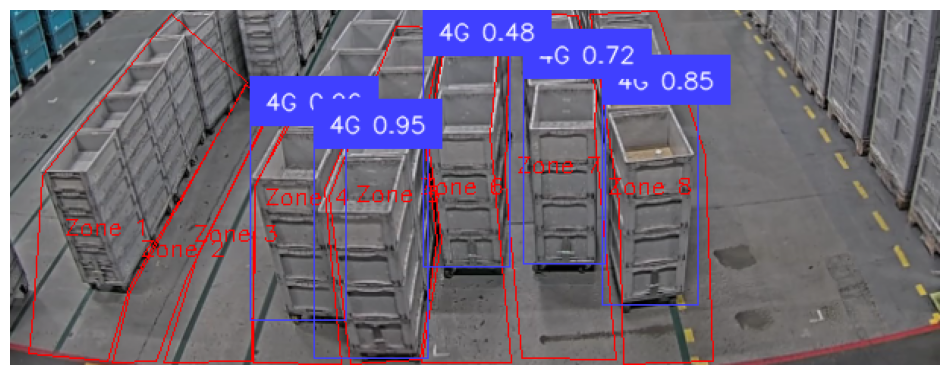

Zone 1: None
Zone 2: None
Zone 3: None
Zone 4: BoxType.G4
Zone 5: BoxType.G4
Zone 6: BoxType.G4
Zone 7: BoxType.G4
Zone 8: BoxType.G4


In [80]:
def identify_each_row(
    front_img_path: Path, zones: dict[int, list[tuple[int, int]]], debug=False, min_conf=0.5
) -> dict[int, BoxType]:
    """
    Return a dictionary where keys are row number and values are box types
    """
    model = YOLO("guide_results/frontview_detection/weights/best.pt")
    frame = cv2.imread(str(front_img_path))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # fix colors

    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)

    detections = detections[detections.confidence > min_conf]

    row_types: dict[int, BoxType] = {}

    for box, class_id, conf in zip(detections.xyxy, detections.class_id, detections.confidence):
        center_x = (box[0] + box[2]) / 2
        center_y = (box[1] + box[3]) / 2
        center_point = (int(center_x), int(center_y))

        # Check which zone contains this point
        for zone_id, zone_points in zones.items():
            if cv2.pointPolygonTest(np.array(zone_points), center_point, False) >= 0:
                if zone_id in row_types:
                    print(f"Warning: Multiple detections in zone {zone_id}")
                row_types[zone_id] = BoxType(model.names[class_id])
                break

    for i in range(len(zones)):
        if i not in row_types:
            row_types[i] = None

    if debug:
        box_annotator = sv.BoxAnnotator(thickness=1)
        label_annotator = sv.LabelAnnotator()

        labels = [
            f"{model.names[class_id]} {confidence:0.2f}"
            for confidence, class_id in zip(detections.confidence, detections.class_id)
        ]

        # Draw zones
        annotated_frame = frame.copy()
        for zone_id, points in zones.items():
            # Draw zone polygon
            cv2.polylines(annotated_frame, [np.array(points)], True, (255, 0, 0), 1)

            # Calculate centroid for zone label
            centroid = np.mean(points, axis=0).astype(int)

            # Get text size to center it
            text = f"Zone {zone_id+1}"
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

            # Adjust centroid coordinates to center the text
            text_x = int(centroid[0] - text_width / 2)
            text_y = int(centroid[1] + text_height / 2)

            cv2.putText(annotated_frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Annotate boxes
        annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_frame)
        plt.axis("off")
        plt.show()

    return row_types


# Example usage
result = identify_each_row("../data/new/test/front.png", zones_front, debug=True, min_conf=0.4)
for i in range(len(result)):
    print(f"Zone {i+1}: {result[i]}")


0: 640x640 91 Boxs, 17.8ms
Speed: 8.0ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


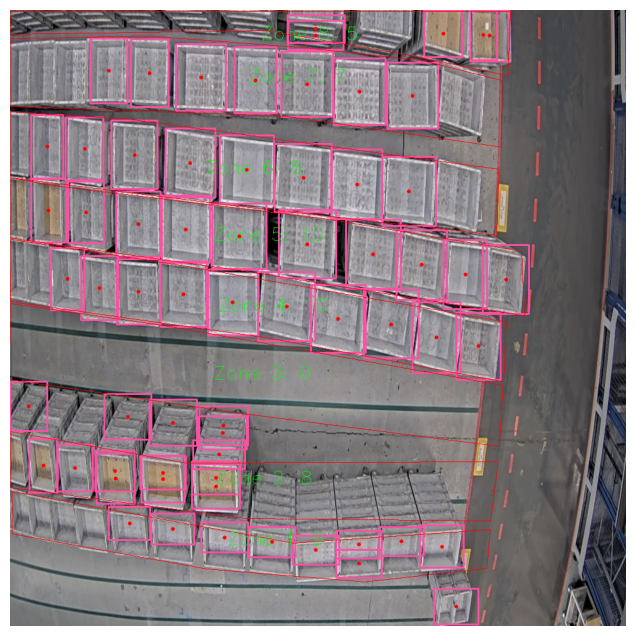

Row 7: 5 boxes
Row 6: 7 boxes
Row 5: 8 boxes
Row 4: 10 boxes
Row 3: 10 boxes
Row 2: 0 boxes
Row 1: 8 boxes
Row 0: 9 boxes


In [81]:
def count_boxes_per_row(
    img_top_path: Path, zones: dict[int, list[tuple[int, int]]], min_conf=0.6, debug=False
) -> dict[int, int]:
    """
    Returns a dict containing the number of boxes in each row, where keys are row numbers and values are the number of boxes
    """
    # Inference for top view
    model = YOLO("guide_results/top_detection4/weights/best.pt")
    frame = cv2.imread(img_top_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get original dimensions
    orig_h, orig_w = frame.shape[:2]

    # Resize frame
    new_h, new_w = 1000, 1000
    frame = cv2.resize(frame, (new_w, new_h))

    # Calculate scale factors
    scale_x = new_w / orig_w
    scale_y = new_h / orig_h

    # Scale zones
    scaled_zones = {}
    for zone_id, points in zones.items():
        scaled_points = [(int(x * scale_x), int(y * scale_y)) for x, y in points]
        scaled_zones[zone_id] = scaled_points

    zones = scaled_zones

    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.confidence > min_conf]

    # Initialize counts for all zones
    boxes_per_row = {i: 0 for i in zones.keys()}

    # For each detection, check which zone it belongs to
    for box, class_id, conf in zip(detections.xyxy, detections.class_id, detections.confidence):
        center_x = (box[0] + box[2]) / 2
        center_y = (box[1] + box[3]) / 2
        center_point = (center_x, center_y)

        # Check which zone contains this point
        for zone_id, zone_points in zones.items():
            zone_polygon = np.array(zone_points)
            if cv2.pointPolygonTest(zone_polygon, center_point, False) >= 0:
                boxes_per_row[zone_id] += 1
                break

    if debug:
        box_annotator = sv.BoxAnnotator()
        annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

        # Draw zones
        for zone_id, points in zones.items():
            # Draw zone polygon
            cv2.polylines(annotated_frame, [np.array(points)], True, (255, 0, 0), 1)

            # Calculate centroid for zone label
            centroid = np.mean(points, axis=0).astype(int)
            text = f"Zone {zone_id+1}: {boxes_per_row[zone_id]}"

            # Get text size to center it
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

            # Adjust centroid coordinates to center the text
            text_x = int(centroid[0] - text_width / 2)
            text_y = int(centroid[1] + text_height / 2)

            cv2.putText(annotated_frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)

        # Draw center points of boxes
        for box in detections.xyxy:
            center_x = int((box[0] + box[2]) / 2)
            center_y = int((box[1] + box[3]) / 2)
            cv2.circle(annotated_frame, (center_x, center_y), 3, (255, 0, 0), -1)  # Draw filled circle

        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_frame)
        plt.axis("off")
        plt.show()

    return boxes_per_row


res = count_boxes_per_row("../data/new/test/top_right.png", zones=zones_top, debug=True, min_conf=0.5)
for i, count in res.items():
    print(f"Row {i}: {count} boxes")


0: 256x640 6 4Gs, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)


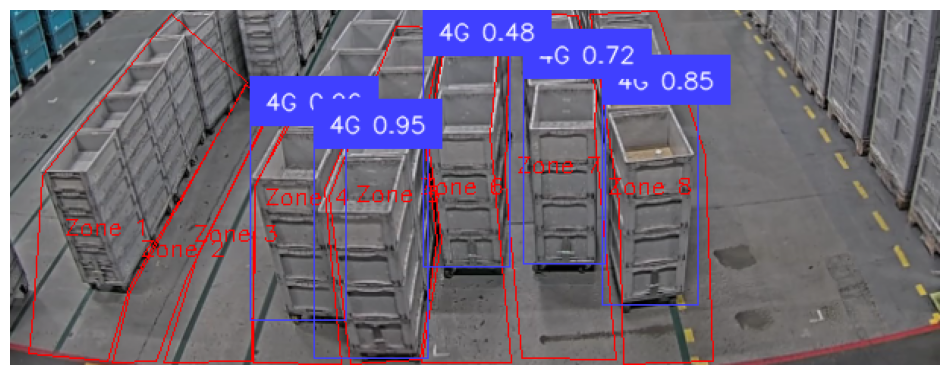


0: 640x640 91 Boxs, 45.8ms
Speed: 5.3ms preprocess, 45.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


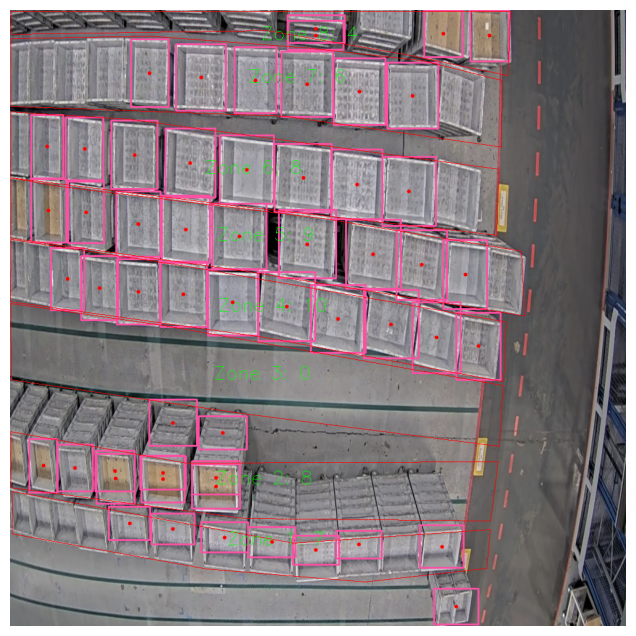

{0: None,
 1: None,
 2: None,
 3: <BoxType.G4: '4G'>,
 4: <BoxType.G4: '4G'>,
 5: <BoxType.G4: '4G'>,
 6: <BoxType.G4: '4G'>,
 7: <BoxType.G4: '4G'>}
{0: 7, 1: 8, 2: 0, 3: 10, 4: 9, 5: 8, 6: 6, 7: 4}


{<BoxType.B4: 'B4'>: 0,
 <BoxType.B8: 'B8'>: 0,
 <BoxType.G4: '4G'>: 37,
 <BoxType.G8: '8G'>: 0,
 <BoxType.G3: '3G'>: 0}

In [82]:
from pprint import pprint
def count_boxes(front_img_path: Path, top_img_path: Path) -> dict[BoxType, int]:
    """
    Return a dict object containing a count for each box type. The keys are the box types and the values are the counts.
    """
    row_types = identify_each_row(front_img_path, zones_front,debug=True,min_conf=0.4)
    boxes_per_row = count_boxes_per_row(top_img_path, zones_top,debug=True)

    pprint(row_types)
    pprint(boxes_per_row)
    
    # Initialize counts for each box type
    box_counts = {box_type: 0 for box_type in BoxType}
    
    # Count boxes of each type
    for row, box_type in row_types.items():
        if box_type is not None:
            box_counts[box_type] += boxes_per_row[row]
    
    return box_counts
    

res = count_boxes("../data/new/test/front.png", "../data/new/test/top_right.png")
res
    